In [1]:
from scipy.stats import pearsonr
import numpy as np
from sklearn.decomposition import FastICA
import matplotlib.pyplot as plt
from time import time

def clean_eeg(recordings_matrix, channel_map, raw_eeg):
	#--------------------
	# This method takes an eeg_matrix of N_channels x T_timestamps
	# along with a channel_map vector of N_channels X 1
	# and returns a clean eeg_matrix of N_channels x T_timestamps
	# while using channels mapped to EEG(0), EOG (1), ECG (2) and EMG (3)
	# as noise sources
	eeg_idnt = 0
	noise_types_num = max(channel_map)
	noise_idnts = range(1, noise_types_num + 1)
	if len(noise_idnts) != noise_types_num:
		print "Bug Found"
		return -1
	N_channels, T_timestamps = recordings_matrix.shape
	print "-I- Number of channels found is", N_channels, "with", T_timestamps, "timestamps"

	## filter out non eeg channels
	eeg_channels = [i for i in range(len(channel_map)) if channel_map[i] == 0]
	eeg_matrix = np.zeros([len(eeg_channels), T_timestamps])
	cnt = 0
	for i in eeg_channels:
		eeg_matrix[cnt, :] = recordings_matrix[i, :]
		cnt = cnt + 1

	## ica: N_Components x T_timestamps	
	n_components = eeg_matrix.shape[0]
	X = eeg_matrix.transpose()
	ica = FastICA(n_components)
	t0 = int(time() * 1000)	
	eeg_ica_components = ica.fit_transform(X)
	delta = int(time() * 1000) - t0
	print "-T- It took", delta, "ms to calculate ICA components"
	eeg_ica_components = eeg_ica_components.transpose()

	## correlation
	for noise_idnt in noise_idnts:
		noise_channels = [i for i in range(len(channel_map)) if channel_map[i] == noise_idnt]
		for noise_channel in noise_channels:
			t0 = int(time() * 1000)
			corr_vec = calculate_correlation(eeg_ica_components, recordings_matrix[noise_channel,:])
			delta = int(time() * 1000) - t0
			print "-T- It took", delta, "ms to calculate CORRELATION of noise with all eeg channels"
			eeg_component_idx = np.argmax(abs(corr_vec))
			eeg_component_idx_min = np.argmin(abs(corr_vec))
			print "-I- Noise component", noise_idnt, "of channel", noise_channel, "is highly correlated with", eeg_component_idx, "with", corr_vec[eeg_component_idx]
			sorted_corr_vector_indices =  np.argsort(corr_vec, 0)

			## Debug: Compare highly/barley correlated signals with ecg sensor
			plt.figure(1)
			plt.subplot(411)
			plt.plot(range(T_timestamps), eeg_ica_components[eeg_component_idx,:])
			plt.xlabel('Times (ms)')
			plt.ylabel('EEG Max-1')

			plt.subplot(412)
			plt.plot(range(T_timestamps), eeg_ica_components[sorted_corr_vector_indices[-2,0],:])
			plt.xlabel('Times (ms)')
			plt.ylabel('EEG Max-2')

			plt.subplot(413)
			plt.plot(range(T_timestamps), eeg_ica_components[sorted_corr_vector_indices[-3,0],:])
			plt.xlabel('Times (ms)')
			plt.ylabel('EEG Max-3')

			plt.subplot(414)
			plt.plot(range(T_timestamps), recordings_matrix[noise_channel,:])
			plt.xlabel('Times (ms)')
			plt.ylabel('ECG')
			plt.show()
            
            ## Debug: Plot spatial
            
			#ica_components = np.zeros(eeg_ica_components.shape)
			#ica_components[eeg_component_idx,:] = eeg_ica_components[eeg_component_idx,:]
			#eeg_reconstructed = ica.inverse_transform(ica_components.transpose())

			## "Throw away" ica component
			eeg_ica_components[eeg_component_idx,:] = np.zeros(eeg_ica_components[eeg_component_idx,:].shape)
    
    ## Reconstruct clean EEG signal
	ch_types = ['eeg']*len(raw_eeg.info['ch_names'])
	data = ica.inverse_transform(eeg_ica_components.transpose()).transpose()
	info = mne.create_info(ch_names=raw_eeg.info['ch_names'], sfreq=raw_eeg.info['sfreq'], ch_types=ch_types)
	raw_eeg = mne.io.RawArray(data, info)
    
	return raw_eeg

In [2]:
def calculate_correlation(eeg_matrix, channel_vector):
	corr_vec = np.zeros([eeg_matrix.shape[0], 1])
	for eeg_component_idx in range(eeg_matrix.shape[0]):
		eeg_component = eeg_matrix[eeg_component_idx,:]
		r, pvalue = pearsonr(eeg_component, channel_vector)
		r = abs(r * (1 - pvalue))
		corr_vec[eeg_component_idx] = r
	return corr_vec

In [3]:
import mne
from mne import io
from mne.datasets import sample
import pickle
import os

data_path = sample.data_path()
raw_fname = data_path + '/MEG/sample/sample_audvis_raw.fif'
# Setup for reading the raw data
raw = io.read_raw_fif(raw_fname)
raw.load_data()
raw_eeg = raw.copy()

## EEG Channels List - load or create
eeg_list_f = 'eeg_channels.list'
if ( os.path.exists(eeg_list_f) ):
    with open (eeg_list_f, 'rb') as fp:
        eeg_channels = pickle.load(fp)
else:
    fig, eeg_channels = raw_eeg.plot_sensors(kind='select', ch_type='eeg', block=True)	
    print "-I- You have chosen the following EEG channels:", eeg_channels

    with open(eeg_list_f, 'wb') as fp:
        pickle.dump(eeg_channels, fp)

## channels
raw_eeg = raw_eeg.pick_channels(eeg_channels)
C = len(eeg_channels)
print "-I- Found",C,"EEG channels"

Opening raw data file C:\Users\HaneenSader\mne_data\MNE-sample-data\MEG\sample\sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
Current compensation grade : 0
add_eeg_ref defaults to True in 0.13, will default to False in 0.14, and will be removed in 0.15. We recommend to use add_eeg_ref=False and set_eeg_reference() instead.
Adding average EEG reference projection.
1 projection items deactivated
Reading 0 ... 166799  =      0.000 ...   277.714 secs...


<ipython-input-3-ac03271afa17>:10: DeprecationWarning: add_eeg_ref defaults to True in 0.13, will default to False in 0.14, and will be removed in 0.15. We recommend to use add_eeg_ref=False and set_eeg_reference() instead.
  raw = io.read_raw_fif(raw_fname)


-I- Found 20 EEG channels


In [4]:
## time window
T = 20 * C * C #20000
print "-I- For ICA to succeed a window of",T,"samples was chosen"
raw = raw.crop(tmin=0, tmax=raw[0][1][T-1])
raw_eeg = raw_eeg.crop(tmin=0, tmax=raw_eeg[0][1][T-1])

-I- For ICA to succeed a window of 8000 samples was chosen


In [5]:
## EEG Frequency filter: keep only 1Hz-60Hz
lf = 1 #hz
hf = 60 #hz
t0 = int(time() * 1000)
raw_eeg = raw_eeg.filter(lf, hf)
delta = int(time() * 1000) - t0
print "-T- It took", delta, "ms to FILTER eeg channels"
eeg_recordings_matrix = raw_eeg[:][0]

Band-pass filtering from 1 - 60 Hz
filter_length (8192) is longer than the signal (8000), distortion is likely. Reduce filter length or filter a longer signal.
Multiple deprecated filter parameters were used:
phase in 0.13 is "zero-double" but will change to "zero" in 0.14
fir_window in 0.13 is "hann" but will change to "hamming" in 0.14
lower transition bandwidth in 0.13 is 0.5 Hz but will change to "auto" in 0.14
upper transition bandwidth in 0.13 is 0.5 Hz but will change to "auto" in 0.14
The default filter length in 0.13 is "10s" but will change to "auto" in 0.14


<ipython-input-5-f9ffb6855277>:5: RuntimeWarning: filter_length (8192) is longer than the signal (8000), distortion is likely. Reduce filter length or filter a longer signal.
  raw_eeg = raw_eeg.filter(lf, hf)
<ipython-input-5-f9ffb6855277>:5: DeprecationWarning: Multiple deprecated filter parameters were used:
phase in 0.13 is "zero-double" but will change to "zero" in 0.14
fir_window in 0.13 is "hann" but will change to "hamming" in 0.14
lower transition bandwidth in 0.13 is 0.5 Hz but will change to "auto" in 0.14
upper transition bandwidth in 0.13 is 0.5 Hz but will change to "auto" in 0.14
The default filter length in 0.13 is "10s" but will change to "auto" in 0.14
  raw_eeg = raw_eeg.filter(lf, hf)


-T- It took 1096 ms to FILTER eeg channels


In [6]:
## ECG Channel
picks = mne.pick_types(raw.info, meg=False, eeg=False, stim=False, eog=False, include=['MEG 1531'], exclude='bads')
print "-I- Number of ECG channels found:", len(picks)
print "-I- The ECG channels found:", picks
ecg_recordings_matrix = raw[picks][0]

-I- Number of ECG channels found: 1
-I- The ECG channels found: [170]


In [7]:
## Prepare data
EEG_channels_count = eeg_recordings_matrix.shape[0]
print "-I- Number of EEG channels found:", EEG_channels_count
ECG_channels_count = ecg_recordings_matrix.shape[0]
T_timestamps = eeg_recordings_matrix.shape[1]
# - data
recordings_matrix = np.zeros([EEG_channels_count + ECG_channels_count, T_timestamps])
for i in range(EEG_channels_count):
    recordings_matrix[i,:] = eeg_recordings_matrix[i,:]
for i in range(ECG_channels_count):
    recordings_matrix[EEG_channels_count+i,:] = ecg_recordings_matrix[i,:]
# - map
channel_map = np.zeros([EEG_channels_count + ECG_channels_count, 1])
for i in range(EEG_channels_count):
    channel_map[i] = 0

for i in range(ECG_channels_count):
    channel_map[EEG_channels_count + i] = 1

-I- Number of EEG channels found: 20


-I- Number of channels found is 21 with 8000 timestamps


C:\Users\HaneenSader\Anaconda2\lib\site-packages\sklearn\decomposition\fastica_.py:116: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


-T- It took 4729 ms to calculate ICA components
-T- It took 15 ms to calculate CORRELATION of noise with all eeg channels
-I- Noise component 1 of channel 20 is highly correlated with 2 with [ 0.31524361]


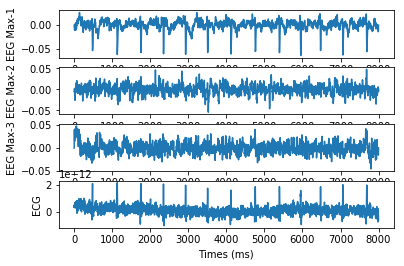

(20L, 8000L)
(8000L, 20L)
[u'EEG 017', u'EEG 025', u'EEG 036', u'EEG 043', u'EEG 035', u'EEG 024', u'EEG 060', u'EEG 058', u'EEG 048', u'EEG 030', u'EEG 012', u'EEG 002', u'EEG 009', u'EEG 015', u'EEG 033', u'EEG 027', u'EEG 044', u'EEG 052', u'EEG 046', u'EEG 050']
600.614990234
['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg']
Creating RawArray with float64 data, n_channels=20, n_times=8000
    Range : 0 ... 7999 =      0.000 ...    13.318 secs
Ready.


In [8]:
raw_eeg_cleaned = clean_eeg(recordings_matrix, channel_map, raw_eeg)

In [10]:
raw_brainwaves = dict()

raw_theta = raw_eeg.filter(l_freq=4, h_freq=7)
raw_brainwaves['theta'] = raw_theta

raw_alpha = raw_eeg.filter(l_freq=8, h_freq=15)
raw_brainwaves['alpha'] = raw_alpha

raw_beta = raw_eeg.filter(l_freq=16, h_freq=31)
raw_brainwaves['beta'] = raw_beta

Band-pass filtering from 4 - 7 Hz
filter_length (8192) is longer than the signal (8000), distortion is likely. Reduce filter length or filter a longer signal.
Multiple deprecated filter parameters were used:
phase in 0.13 is "zero-double" but will change to "zero" in 0.14
fir_window in 0.13 is "hann" but will change to "hamming" in 0.14
lower transition bandwidth in 0.13 is 0.5 Hz but will change to "auto" in 0.14
upper transition bandwidth in 0.13 is 0.5 Hz but will change to "auto" in 0.14
The default filter length in 0.13 is "10s" but will change to "auto" in 0.14


<ipython-input-10-3e61f84c9be0>:3: RuntimeWarning: filter_length (8192) is longer than the signal (8000), distortion is likely. Reduce filter length or filter a longer signal.
  raw_theta = raw_eeg.filter(l_freq=4, h_freq=7)
<ipython-input-10-3e61f84c9be0>:3: DeprecationWarning: Multiple deprecated filter parameters were used:
phase in 0.13 is "zero-double" but will change to "zero" in 0.14
fir_window in 0.13 is "hann" but will change to "hamming" in 0.14
lower transition bandwidth in 0.13 is 0.5 Hz but will change to "auto" in 0.14
upper transition bandwidth in 0.13 is 0.5 Hz but will change to "auto" in 0.14
The default filter length in 0.13 is "10s" but will change to "auto" in 0.14
  raw_theta = raw_eeg.filter(l_freq=4, h_freq=7)


Band-pass filtering from 8 - 15 Hz
filter_length (8192) is longer than the signal (8000), distortion is likely. Reduce filter length or filter a longer signal.
Multiple deprecated filter parameters were used:
phase in 0.13 is "zero-double" but will change to "zero" in 0.14
fir_window in 0.13 is "hann" but will change to "hamming" in 0.14
lower transition bandwidth in 0.13 is 0.5 Hz but will change to "auto" in 0.14
upper transition bandwidth in 0.13 is 0.5 Hz but will change to "auto" in 0.14
The default filter length in 0.13 is "10s" but will change to "auto" in 0.14


<ipython-input-10-3e61f84c9be0>:6: RuntimeWarning: filter_length (8192) is longer than the signal (8000), distortion is likely. Reduce filter length or filter a longer signal.
  raw_alpha = raw_eeg.filter(l_freq=8, h_freq=15)
<ipython-input-10-3e61f84c9be0>:6: DeprecationWarning: Multiple deprecated filter parameters were used:
phase in 0.13 is "zero-double" but will change to "zero" in 0.14
fir_window in 0.13 is "hann" but will change to "hamming" in 0.14
lower transition bandwidth in 0.13 is 0.5 Hz but will change to "auto" in 0.14
upper transition bandwidth in 0.13 is 0.5 Hz but will change to "auto" in 0.14
The default filter length in 0.13 is "10s" but will change to "auto" in 0.14
  raw_alpha = raw_eeg.filter(l_freq=8, h_freq=15)


Band-pass filtering from 16 - 31 Hz
filter_length (8192) is longer than the signal (8000), distortion is likely. Reduce filter length or filter a longer signal.
Multiple deprecated filter parameters were used:
phase in 0.13 is "zero-double" but will change to "zero" in 0.14
fir_window in 0.13 is "hann" but will change to "hamming" in 0.14
lower transition bandwidth in 0.13 is 0.5 Hz but will change to "auto" in 0.14
upper transition bandwidth in 0.13 is 0.5 Hz but will change to "auto" in 0.14
The default filter length in 0.13 is "10s" but will change to "auto" in 0.14


<ipython-input-10-3e61f84c9be0>:9: RuntimeWarning: filter_length (8192) is longer than the signal (8000), distortion is likely. Reduce filter length or filter a longer signal.
  raw_beta = raw_eeg.filter(l_freq=16, h_freq=31)
<ipython-input-10-3e61f84c9be0>:9: DeprecationWarning: Multiple deprecated filter parameters were used:
phase in 0.13 is "zero-double" but will change to "zero" in 0.14
fir_window in 0.13 is "hann" but will change to "hamming" in 0.14
lower transition bandwidth in 0.13 is 0.5 Hz but will change to "auto" in 0.14
upper transition bandwidth in 0.13 is 0.5 Hz but will change to "auto" in 0.14
The default filter length in 0.13 is "10s" but will change to "auto" in 0.14
  raw_beta = raw_eeg.filter(l_freq=16, h_freq=31)
